In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import warnings
warnings.simplefilter("ignore")


In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision

from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage

In [3]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

from PIL import Image

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_trans = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

test_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [5]:
train_data = datasets.ImageFolder('../input/cat-and-dog/training_set/training_set/', transform=train_trans)
test_data = datasets.ImageFolder('../input/cat-and-dog/test_set/test_set/', transform=test_trans)

In [6]:
train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=100,
    shuffle=True)
    

test_loader = torch.utils.data.DataLoader(test_data,
    batch_size=100,
    shuffle=False)

In [7]:
to_pil = transforms.ToPILImage()

In [8]:
def show_data(data_sample):
    result = to_pil(data_sample)
    plt.imshow(result)
    plt.title('y = '+ str(data_sample[1]))

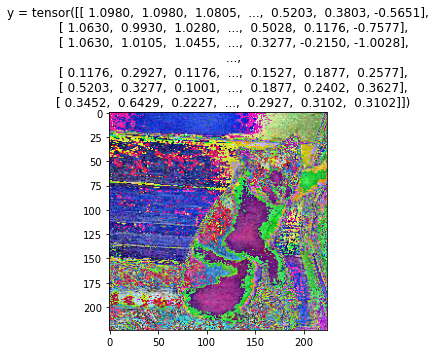

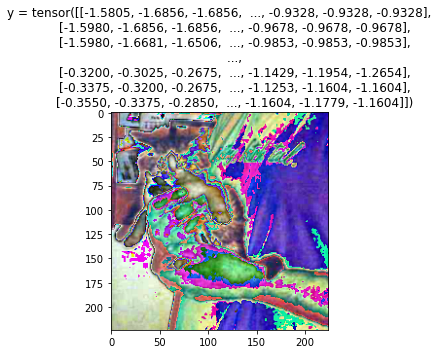

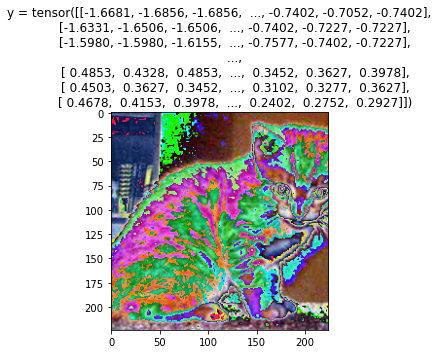

In [9]:
for n,data_sample in enumerate(test_data):
    show_data(data_sample[0])
    plt.show()
    if n==2:
        break        

In [10]:
from torchvision.models import resnet50
model = resnet50(pretrained=True).cuda()
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 270),
               nn.ReLU(inplace=True),
               nn.Linear(270,90 ),
               nn.ReLU(inplace=True),
               nn.Linear(90,2)).cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.003
    weight_decay: 0
)

In [13]:
val_acc=[]
loss_list=[]
train_acc =[]
for epoch in range(10):
    loss_sublist = []
    corr = 0
    for x, y in train_loader:
        model.train()
        optimizer.zero_grad()
        x = x.cuda()
        y = y.cuda()
        preds = model(x)
        loss = criterion(preds, y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
       
        _, yhat = torch.max(preds.data, 1)
        corr += (yhat == y).sum().item()
        print(".",end='',flush = True )
    
    loss_list.append(np.mean(loss_sublist))
    acc = corr/len(train_data)
    print("Training Accuracy at epoch",epoch+1,"is: ",acc)
    train_acc.append(acc)
    
    correct=0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            model.eval()
            x_test = x_test.cuda()
            y_test = y_test.cuda()
            z = model(x_test)
            _, yhat1 = torch.max(z.data, 1)
            correct += (yhat1 == y_test).sum().item()
    accuracy = correct / len(test_data)
    print("Validation Accuracy at epoch",epoch+1,"is: ",accuracy)
    val_acc.append(accuracy)     

.................................................................................Training Accuracy at epoch 1 is:  0.8739537788881949
Validation Accuracy at epoch 1 is:  0.9836875926841325
.................................................................................Training Accuracy at epoch 2 is:  0.946158650843223
Validation Accuracy at epoch 2 is:  0.967869500741473
.................................................................................Training Accuracy at epoch 3 is:  0.9332916926920675
Validation Accuracy at epoch 3 is:  0.9797330696984676
.................................................................................Training Accuracy at epoch 4 is:  0.9494066208619613
Validation Accuracy at epoch 4 is:  0.972318339100346
.................................................................................Training Accuracy at epoch 5 is:  0.9422860712054966
Validation Accuracy at epoch 5 is:  0.9812160158180919
..........................................................

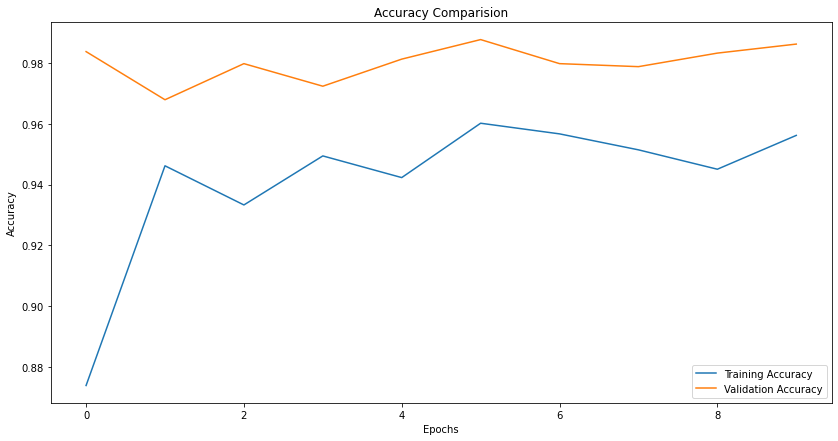

In [14]:
plt.figure(figsize=(14,7))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Comparision')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

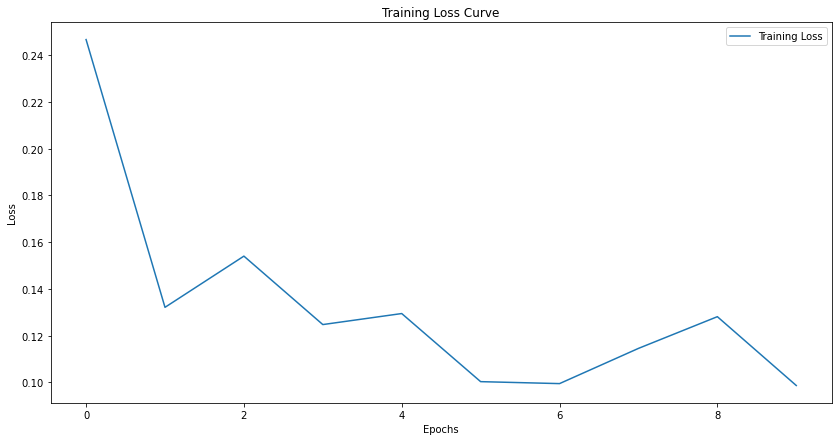

In [15]:
plt.figure(figsize=(14,7))
plt.plot(loss_list,label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [16]:
!mkdir models
!mkdir models/pytorch

In [17]:
torch.save(model.state_dict(), 'models/pytorch/model.pth')